In [1]:
import torch
import torch.nn as nn
import numpy as np

from tda import TDAActivation

### Model

TDANetwork is a simple Deep Learning Model that takes in a time series and outputs a prediction. The main difference that it uses Temporal Decaying Accumulation (TDA) to process the time series. TDA is a simple way to process time series data that is similar to a moving average. The main difference is that it uses a decaying weight for each time step. This allows the model to focus on more recent data and ignore older data. This is useful for time series data that is constantly changing. For example, stock prices are constantly changing and it is more important to focus on recent data than older data.

#### More on Temporal Decaying Accumulation (TDA)

Temporal Decaying Accumulator (TDA) is a novel activation function designed for handling time-dependent data in neural networks. The primary objective of TDA is to emphasize the importance of recent information while diminishing the influence of older data. This is achieved through the use of an exponential decay function that computes the weights for inputs based on their age, and a clipping mechanism that limits the maximum value of the output.
Key Components of TDA:
1. Exponential Decay Function: The TDA activation function incorporates an exponential decay function to compute the weights for each input based on its age. The decay function is defined as:w(t) = a * exp(-t / τ)where t is the time step or age of the input, τ is the time constant that controls the rate of decay, and a is a scaling factor that adjusts the overall magnitude of the weights.
2. Weighted Sum of Inputs: TDA computes the weighted sum of inputs within a specified time window. The weighted sum is calculated as:TDA(x_t) = sum(w(t) * x_(t-i)) for i in range(0, N) where x_t is the input at the current time step t, N is the size of the time window, w(t) is the weight function defined earlier, and x_(t-i) is the input at the previous time step t-i.
3. Clipping Mechanism: The output of the TDA function is clipped to a maximum value to prevent it from growing indefinitely. The clipped output is computed as:TDA_clipped(x_t) = min(TDA(x_t), V_max)where V_max is the maximum value allowed for the TDA function output.


In [2]:
class TDANetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_window, max_value, scaling_factor):
        super(TDANetwork, self).__init__()
        self.layer1 = nn.Linear(input_size * time_window, hidden_size)
        self.ac = TDAActivation(time_window, max_value, scaling_factor)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the input tensor along the time_window dimension
        x = self.layer1(x)
        x = x.unsqueeze(-1)  # Add an extra dimension for the time_window
        x = self.ac(x)
        x = self.layer2(x)
        return x

### Download data 

We're using Individual household electric power consumption from UCI dataset.
This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

Obtain it from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip)
and unzip it to the same directory as this notebook.

In [3]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the dataset
data_path = 'household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'])
data = data.set_index('dt').dropna()
data = data.resample('h').mean()

# Prepare the data
sequence_length = 5
X = np.array([data[i: i + sequence_length].values for i in range(len(data) - sequence_length)])
y = np.array(data.iloc[sequence_length:]['Global_active_power'].values)

X[np.isnan(X)] = 0
y[np.isnan(y)] = 0

# Scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader instances for train and test sets
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [4]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            # print(f'Outputs {outputs} -> y {batch_y}')
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Apply gradient clipping
            optimizer.step()
            losses.append(loss.item())

        train_losses.append(np.mean(losses))

        # Evaluate the model on the test set
        model.eval()
        test_losses = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_losses.append(loss.item())

        print(f"\r{model.ac}: Epoch [{epoch+1}/{num_epochs}], Test Loss: {np.mean(test_losses):.4f}", end="")
    
    print()
    return train_losses, test_losses

In [5]:
input_size = X.shape[-1]
hidden_size = 64
output_size = 1
time_window = 5
max_value = 1.0
scaling_factor = 0.1  # Use a smaller scaling factor

model = TDANetwork(input_size, hidden_size, output_size, time_window, max_value, scaling_factor)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Use a smaller learning rate

num_epochs = 50
tda_loss, tda_test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)

TDAActivation(): Epoch [50/50], Test Loss: 0.0071


### Comparing performance with ReLU and LeakyReLU

To compare the performance of TDA with ReLU and LeakyReLU, we will use the same model architecture and hyperparameters for tow other popular activation functions.

In [6]:
class GenericNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ac=nn.ReLU):
        super(GenericNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.ac = ac()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor along the sequence length dimension
        x = self.layer1(x)
        x = self.ac(x)
        x = self.layer2(x)
        return x

input_size = X.shape[-1] * X.shape[-2]  # Multiply the sequence length with the number of features
hidden_size = 64
output_size = 1

model = GenericNetwork(input_size, hidden_size, output_size, ac=nn.ReLU)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Use a smaller learning rate

# num_epochs = 10
relu_loss, relu_test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)

model = GenericNetwork(input_size, hidden_size, output_size, ac=nn.LeakyReLU)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Use a smaller learning rate

lrelu_loss, lrelu_test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)


ReLU(): Epoch [50/50], Test Loss: 0.0077
LeakyReLU(negative_slope=0.01): Epoch [50/50], Test Loss: 0.0079


### Results

We can see that TDA performs better than ReLU and LeakyReLU. This is because TDA is designed to handle time series data. It is able to focus on more recent data and ignore older data. This is useful for time series data that is constantly changing. As shown in the current example, the function can better predict future consumption per houshold, since the pattern changes over time and it is more important to focus on recent data than older data.

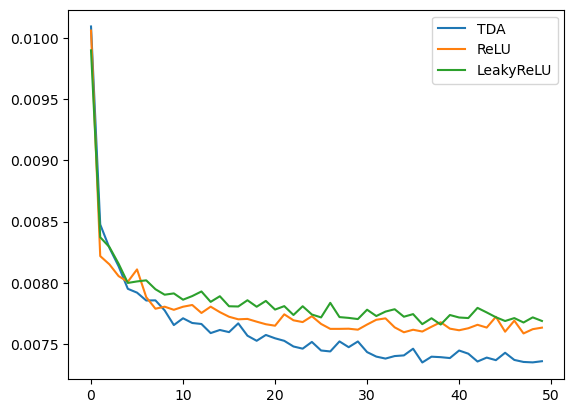

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tda_loss, label='TDA')
plt.plot(relu_loss, label='ReLU')
plt.plot(lrelu_loss, label='LeakyReLU')
plt.legend()
plt.show()